In [1]:
# data storage and handling
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import string 

# ignore warnings  
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ============================ CHANGE HERE ==================================== # 

PATH_GENR_res = '/PATH TO/date_GENR_Results.xlsx'  # <== fill in the path to the GenR results file
PATH_ALSP_res = '/PATH TO/date_ALSPAC_Results.xlsx'# <== fill in the path to the ALSPAC results file

#PATH_GENR_scat = '/PATH TO/GenR_Fig3_scatter.jpg'  # <== fill in the path to the GenR scatterplot figure
#PATH_ALSP_scat = '/PATH TO/ALSPAC_Fig3_scatter.jpg'# <== fill in the path to the GenR scatterplot figure

output_path = "/PATH TO OUTPUT/"                   # <== Where do you want the figures to be saved.

# ============================================================================= #

In [2]:
PATH_GENR_res = '/Users/Serena/Desktop/ELSpaper/GenR-results/2022-04-15_GENR_Results.xlsx'  # <== fill in the path to the GenR results file
PATH_ALSP_res = '/Users/Serena/Desktop/ELSpaper/ALSPAC-results/2022-04-15_ALSPAC_Results.xlsx'

PATH_GENR_scat = '/Users/Serena/Desktop/ELSpaper/GenR-results/genr_scatter_group.jpeg'  # <== fill in the path to the GenR scatterplot figure
PATH_ALSP_scat = '/Users/Serena/Desktop/ELSpaper/ALSPAC-results/1_groups_scat_alspac.jpg'# <== fill in the path to the GenR scatterplot figure

output_path ='/Users/Serena/Desktop/JCAAP/'

In [3]:
def read_res_sheets(path, cohort, print_names = False):
    xl = pd.ExcelFile(path) # read multiple sheets
    # initiate list to store of all sheet names 
    res = list()
    # loop through the sheets and save the contents in separate dataframes
    for sheet in xl.sheet_names:
        df_name = cohort+'_'+sheet # to avoid var names problems
        res.append(df_name)
        globals()[df_name] = xl.parse(sheet) # convert to dataframe
        if 'term' in globals()[df_name].columns: # set the effect as index
            globals()[df_name] = globals()[df_name].set_index('term') 
        else:
            globals()[df_name] = globals()[df_name].set_index('Effect')
        
        # I made a mistake (OR calculation in ALSPAC is reverse). Let's fix it:
        if df_name[5:11] == 'comorb':
            k = np.exp(globals()[df_name]['estimate'])
            sd = [i*1.96 for i in globals()[df_name]['std.error']]
            lci = [np.exp(a - b) for a, b in zip(globals()[df_name]['estimate'], sd)]
            uci = [np.exp(a + b) for a, b in zip(globals()[df_name]['estimate'], sd)]
            globals()[df_name]['OR'] = k
            globals()[df_name]['lci'] = lci
            globals()[df_name]['uci'] = uci
        
        # group by model (covariate / prenatal only / postnatal only / prenatal+postnatal)
        if 'model' in globals()[df_name].columns:
            globals()[df_name]['outcome'] = globals()[df_name]['model'].str.split(" - ", expand = True)[0]
            globals()[df_name]['model'] = globals()[df_name]['model'].str.split(" - ", expand = True)[1]
            globals()[df_name] = globals()[df_name].groupby(globals()[df_name]['model'])
            
    if print_names: 
        print(res, '\n') # for reference 

    return([globals()[df] for df in res])

# ========================================================================================================

read_res_sheets( PATH_GENR_res, 'GENR');
read_res_sheets( PATH_ALSP_res, 'ALSP');

# only model, saves some time
GENR_comorb_dm = GENR_comorb_dm.get_group('domain model')
ALSP_comorb_dm = ALSP_comorb_dm.get_group('domain model')

In [6]:
# Read in the scatterplots created before for Figure 3
# imgR = mpimg.imread( PATH_GENR_scat )
# imgA1 = mpimg.imread( PATH_ALSP_scat )
# imgA2 = mpimg.imread( '/Users/Serena/Desktop/ALSPAC_Fig3_scatter.jpg' )
# imgA = np.hstack([imgA1[85:5175,:5000],imgA2[:,5000:]])

In [4]:
# general plotting parameters 
plt.rcParams["font.family"] = "arial"
fmt = 'o'; elw = 2; caps = 7; alph = 0.7
# specify more readable names for the effect labels
effects = ['Prenatal stress','Postnatal stress','Female sex','Age','Ethnicity','Maternal BMI','Maternal smoking','Maternal drinking']
   
def bold_significant(add_df, start, end, ax):
    sign = add_df[start:end].reset_index().index[add_df[start:end]['p.value']<0.050].to_list()
    for pos in sign:
        ax.get_yticklabels()[pos].set_weight("bold") 
# the following functions assume a figure called f and a set of axes called axs
def add_letters(left=-0.45, up=1.1, from_letter=0, s=20): # add letters to each subplot
    for n, aa in enumerate(axs.flat):
        n = n+from_letter
        aa.text(left, up, string.ascii_uppercase[n]+'.', transform=aa.transAxes, size=s, weight='bold')
def add_cohorts_suptitle(R=0.3, A=0.8): # add title to figures
    f.text(R, 1, 'GenR',  ha='center', fontsize=30, fontweight='bold', color='k')
    f.text(A, 1, 'ALSPAC',ha='center', fontsize=30, fontweight='bold', color='k')
def save_figure(filename, pad=2, dpi=500):
    f.tight_layout(pad=pad)
    f.savefig( output_path + filename+'.tiff', format='tiff', bbox_inches='tight', dpi=dpi)
    

# Main Figures

In [131]:
t1 = pd.read_excel('/Users/Serena/Desktop/ELSpaper/ELStimepre.xlsx')
t2 = pd.read_excel('/Users/Serena/Desktop/ELSpaper/ELStimepos.xlsx')

for t in [t1, t2]:
    t['it_name'] = [x.replace("_", " ") for x in t.item]
    op = [' (']*len(t.item)
    cl = [')']*len(t.item)
    t['it'] = t.it_name + op + t.cohort + cl
    t['retros'] = t['retros'].fillna(0) 
    t.set_index(t.it, inplace=True)

t1[['from','to']] = t1[['from','to']].fillna(0) 

from matplotlib.patches import Rectangle


def stress_time(ax, t=t1, xlim=[-27.5, 40], ylim=[-0.5, 100.5],
                title='Prenatal stress', xlabel='Time (weeks gestation)',
                domain_cuts=[-1, 28, 44, 65, 96], domain_offset=3.8,
                ticks = ['','','0','20',' Birth'], time_grid=[13.3,26.6]):
    # background colors
    domain_colors = ['y','r','b','g','darkviolet']
    domain_names = ['LIFE EVENTS','CONTEXTUAL RISK','PARENTAL RISK','INTERPERSONAL RISK','DIRECT VICTIMIZATION']
    
    for c in range(len(domain_cuts)-1):
        ax.axhspan(domain_cuts[c]+.5, domain_cuts[c+1]+.4, facecolor=domain_colors[c], alpha=0.08)
        #offset = (domain_cuts[c+1] - domain_cuts[c])+10 - len(domain_names[c])
        #dm_name = '  ' * offset + domain_names[c]
        ax.text(xlim[0]-domain_offset, domain_cuts[c]+1.1, domain_names[c], rotation=90, va='top', ha='right', 
                fontsize=20, fontweight='bold', color='k',alpha=0.7,
                bbox=dict(facecolor=domain_colors[c], edgecolor=domain_colors[c], alpha=0.1, pad=10.0))
        # ax.add_patch(Rectangle((xlim[0]-0.2,domain_cuts[c]+.5), 0.2, domain_cuts[c+1]+.4-domain_cuts[c]+.5, 
        #             color=domain_colors[c]))

    for it in t.it.unique():
        
        if type(t.loc[it, 'retros']) == np.float64:
            ax.fill_betweenx(y = it, x1 = t.loc[it, 'retros'], x2 = t.loc[it, 'meas'], color = 'grey', lw = 9, alpha = 0.2)
            if title=='Prenatal stress':
                ax.fill_betweenx(y = it, x1 = t.loc[it, 'from'], x2 = t.loc[it, 'to'], color = 'mediumblue', lw = 9.9, alpha = 1)
        else:
            for m, tm in enumerate(t.loc[it, 'retros']):
                ax.fill_betweenx(y = it, x1 = tm, x2 = t.loc[it, 'meas'][m], 
                                 color = 'grey', lw = 9, alpha = 0.2)
    # Add vertical lines for reference
    ax.axvline(x = 0, color = 'black', linewidth = 0.6)
    for i in time_grid:
        ax.axvline(x = i, color = 'grey', linewidth = 0.6, dashes = [10,2]) 

    color = ['crimson' if c == 'A' else 'mediumblue' for c in t.cohort]

    t.plot(kind='scatter', x='meas', y='it', marker = "|", s = 100, ax = ax, color=color, linewidth=3, fontsize=15)
    
    if title=='Postnatal stress': 
        ax.set_xticks(range(0,len(ticks)))
                      
    ax.set(xlim=xlim, ylim=ylim)

    ax.tick_params(axis='y', direction='in', width=1, length=8)        
    
    labels = [item[:-4] for item in t.it.unique()]
    ax.set_yticklabels(labels, fontsize = 20, fontweight = 'bold')

    ax.set_xticklabels(ticks, fontsize = 20)

    ax.invert_yaxis()
    ax.yaxis.tick_right()

    # change the color of the y labels to separate prenatal and postnatal items
    for i, n in enumerate(list(t.it.unique())):
        if n[-2] == "A":
            ax.get_yticklabels()[i].set_color('crimson')
        else: 
            ax.get_yticklabels()[i].set_color('mediumblue')

    ax.set_title(title, fontsize = 30, fontweight = 'bold', pad=10)
    ax.set_xlabel(xlabel, fontsize = 20, fontweight = 'bold')
    ax.set(ylabel=None)

# ---------------------------------------------------------------------------------
    


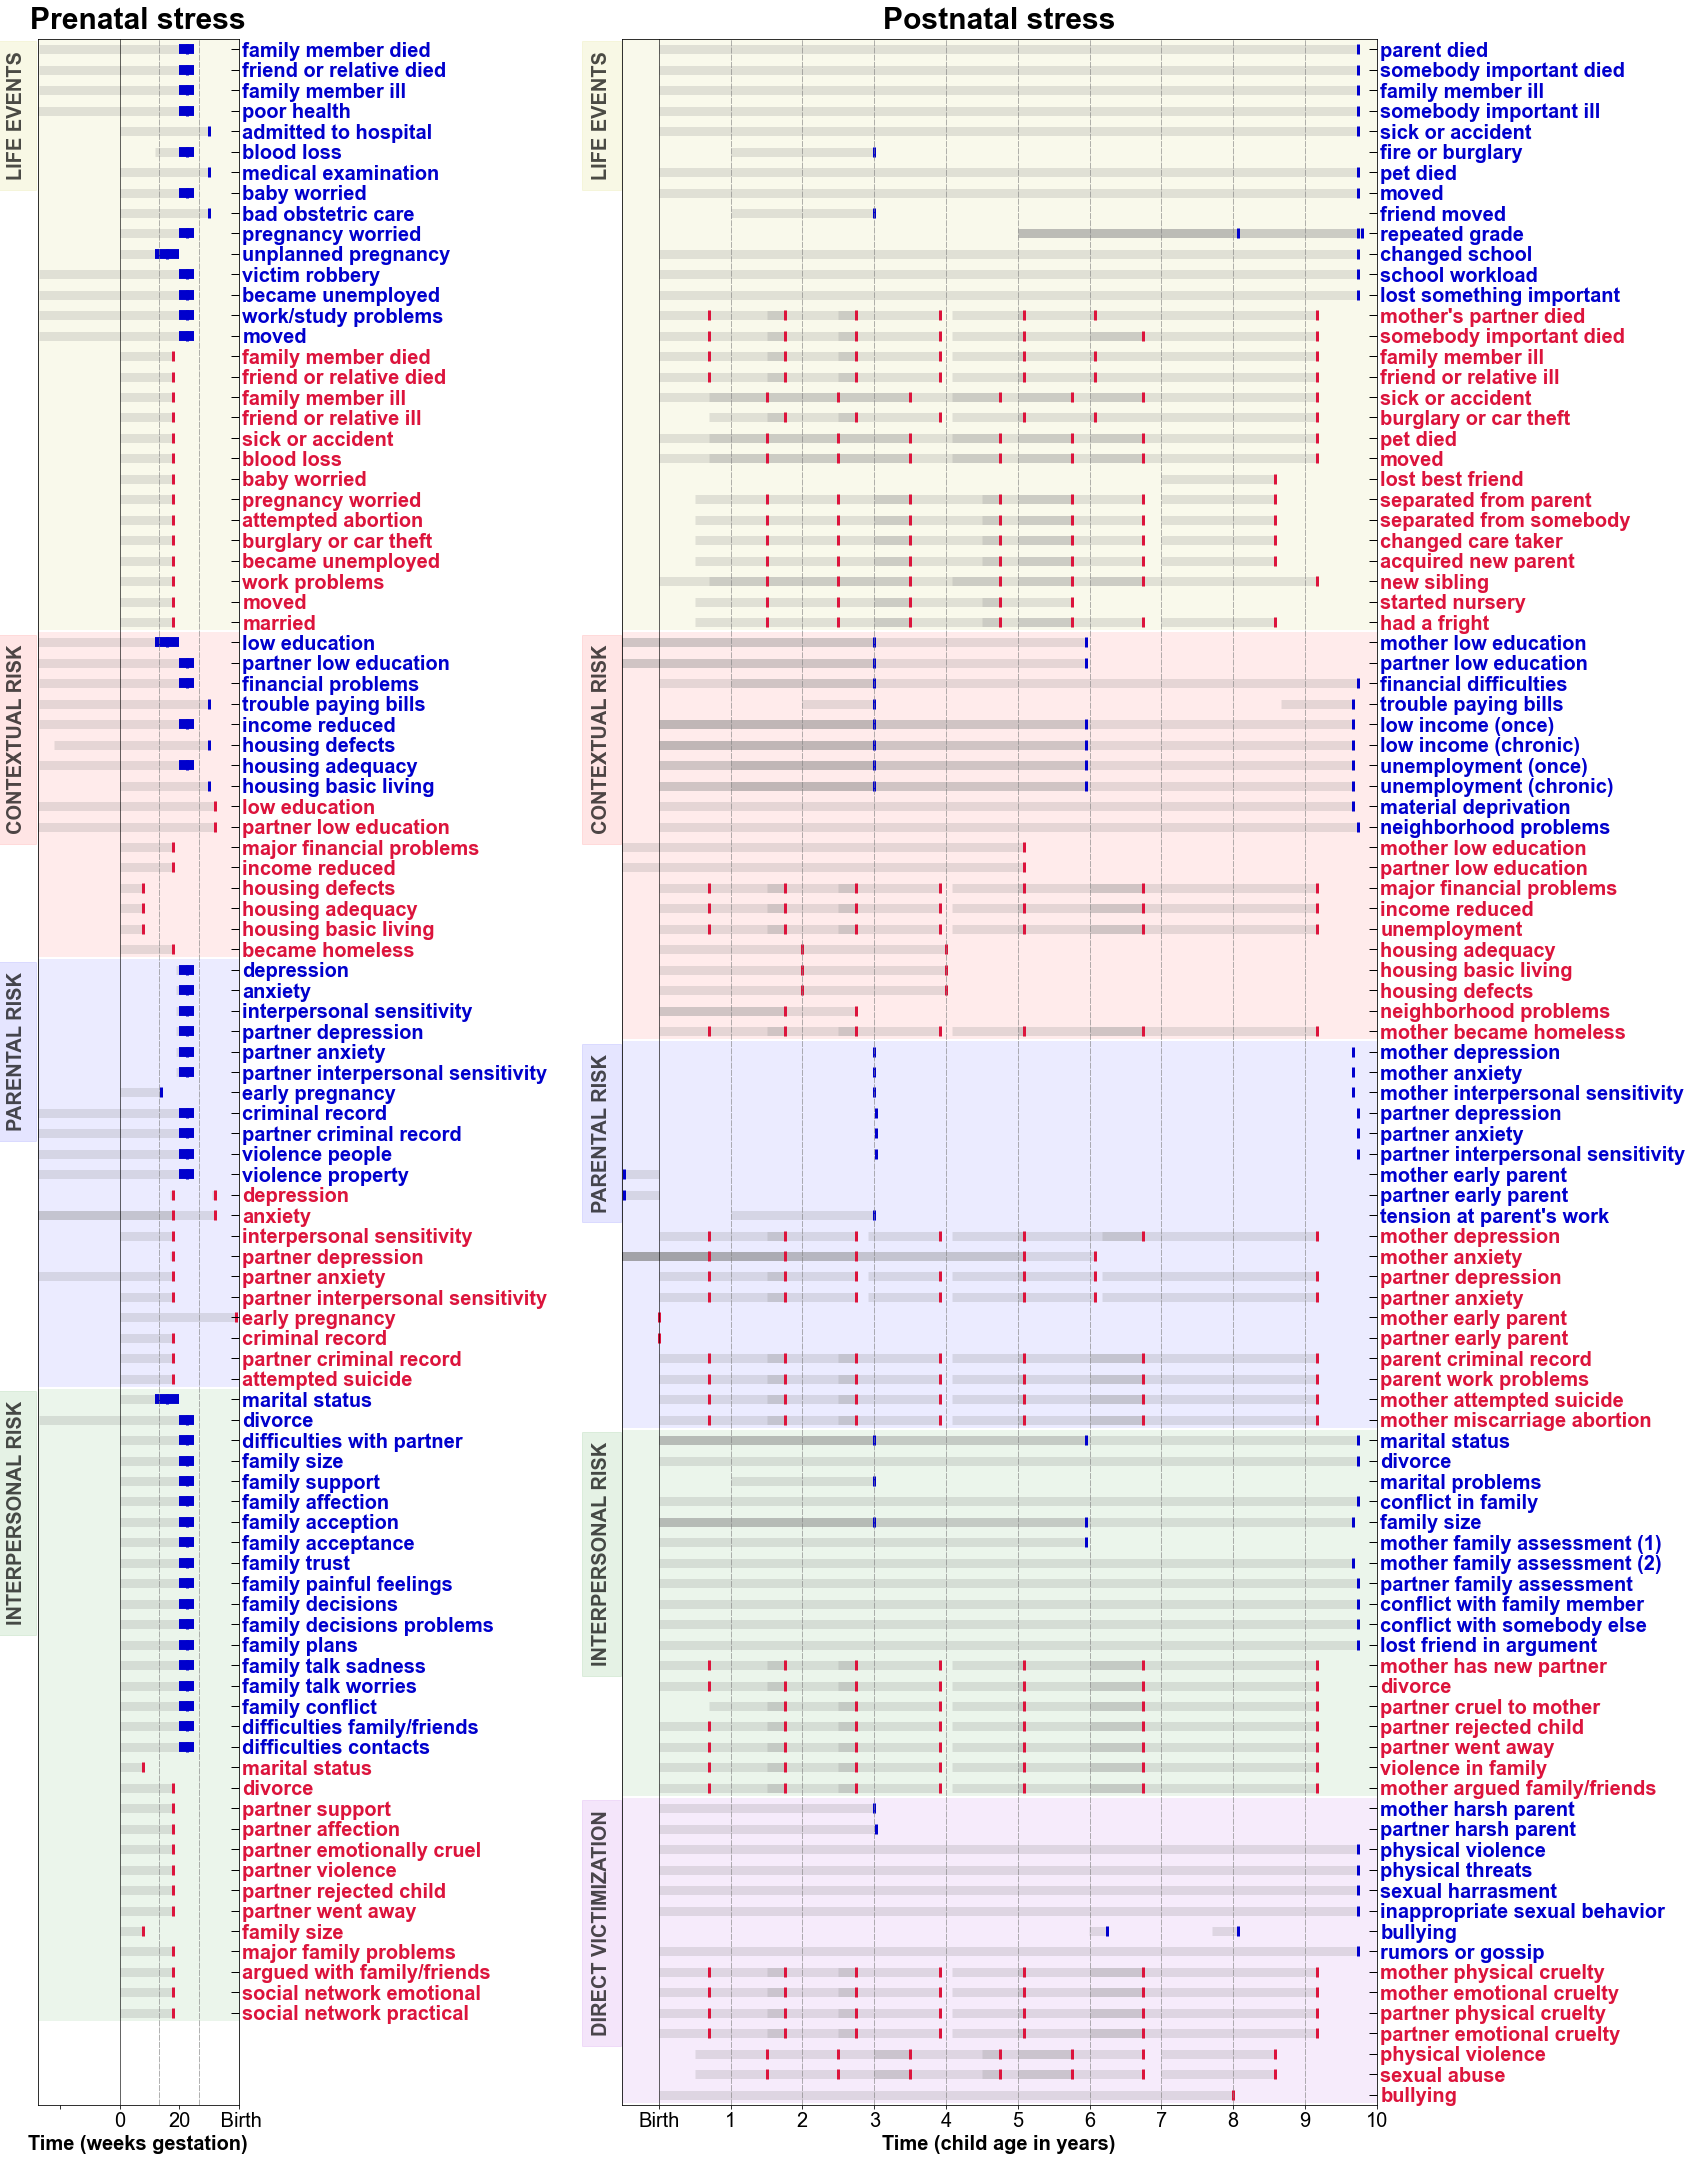

In [134]:
f = plt.figure(figsize=(24,38))

plt.rcParams["font.family"] = "arial"

# Add a gridspec
gs = f.add_gridspec(1, 2,  width_ratios=(4, 15), wspace = 0.8)

# Main scatterplot ax
ax1 = f.add_subplot(gs[0, 0])
ax2 = f.add_subplot(gs[0, 1])

stress_time(ax1)
stress_time(ax2, t=t2, xlim=[-0.52, 10], ylim=[-0.5, 100.5], 
                 title='Postnatal stress', xlabel='Time (child age in years)',
                 domain_cuts=[-1, 28, 48, 67, 85, 100], domain_offset=0.15,
                 ticks = ['Birth']+[str(i) for i in range(1,11)], time_grid=range(1,10))

f.tight_layout()
f.savefig( output_path +'F1_ELStime.tiff', format='tiff', bbox_inches='tight', dpi=500)

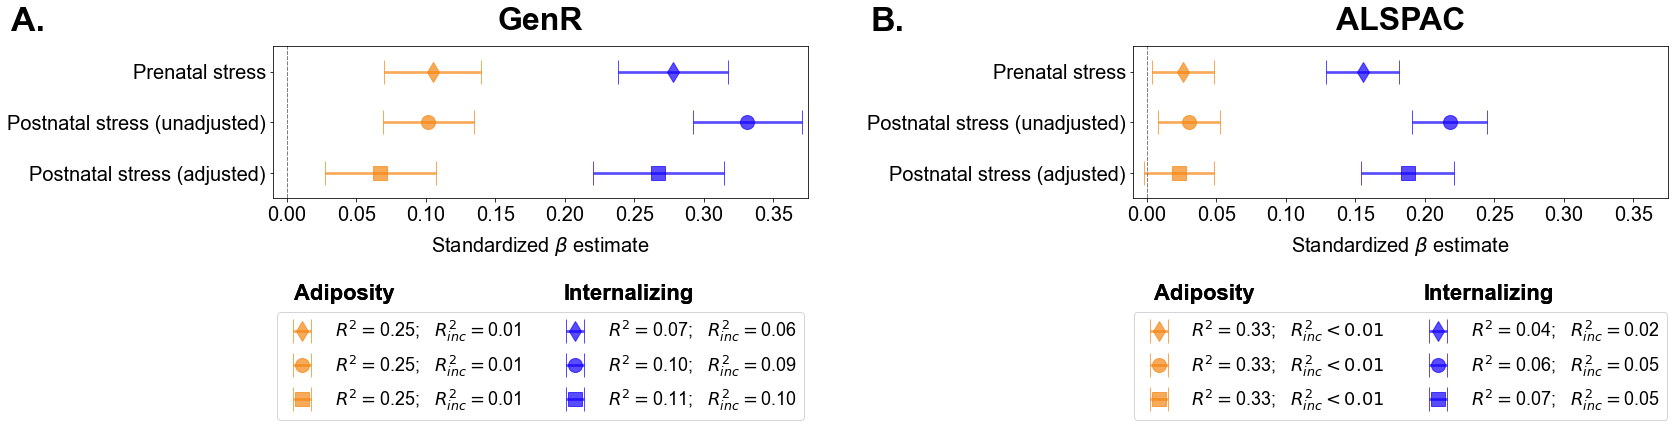

In [138]:
def regr_plot(model, ax, title, xlims=(-0.01, 0.375), colors=['grey','k', 'k'], sex='', leg='best'):
    
    # get to the estimates
    def extract_est(mod, adj, pred):
        outp = mod.get_group(adj).loc[pred]
        outp.loc['rsq'] = mod.get_group(adj)['rsq'][0]
        return(outp)
    
    pren = extract_est(model, 'pren model', 'prenatal_stress_z')
    post = extract_est(model, 'post model', 'postnatal_stress_z')
    addt = extract_est(model, 'pren+post model', 'postnatal_stress_z')
    md = pd.concat([pren, post, addt], axis=1).T
    
    baser = model.get_group('base model')['rsq'][0] # get R2 for the covariate only model

    lbls = ['Prenatal stress', 'Postnatal stress (unadjusted)', 'Postnatal stress (adjusted)']
    markers = ['d','o','s'] # circle, circle, square
    
    for n in range(3): # md.index for y
        incR = round(md.rsq[n]- baser,2) # incremental R2
        inclab = ';   $R^{2}_{inc}<0.01$' if incR < 0.01 else ';   $R^{2}_{inc}=$%0.2f'%incR
        if len(sex)>1: # sex-stratified plots
            ax.errorbar([md['estimate'][n]], [lbls[n]], xerr = [md['std.error'][n]*1.96], color = colors,
                         label = sex, ms=14, fmt = markers[n], elinewidth = 2.7, capsize = 12, alpha = alph)
        else: # main models plot 
            ax.errorbar([md['estimate'][n]], [lbls[n]], xerr = [md['std.error'][n]*1.96], color = colors[n],
                        label = '$R^{2}=$%0.2f'%round(md.rsq[n],2) + inclab,
                        ms=14, fmt = markers[n], elinewidth = 2.7, capsize = 12, alpha = alph)
    ax.set_ylim(-0.5,2.5)
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=20)
    # add a vertical dotted line indicating beta = 0 or OR = 1.
    ax.axvline(x = 0, ymin = -1, ymax = 4, color = 'grey', ls = '--', lw = 1)
    ax.set_xlim(xlims)
    # Add x-label
    ax.set_xlabel(r'Standardized $\beta $ estimate', fontsize=20, labelpad=10)

    # add a legend 
    if len(sex)>1:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), fontsize=15, loc=leg, ncol=1)
    elif leg !='off':
        ax.legend(fontsize=18, bbox_to_anchor=(0.5, -1.1), loc='center', ncol=2) #loc=leg
    
    ax.text(0.005, 4.5, 'Adiposity', fontsize=22, fontweight='bold')
    ax.text(0.199, 4.5,'Internalizing',fontsize=22, fontweight='bold')
    # add a title 
    ax.set_title(title, fontweight = 'bold', fontsize = 32, pad =16)

# ========================================================================================================
#f, axs = plt.subplots(1, 2, figsize=(25, 2.8), constrained_layout = True)

f, axs = plt.subplot_mosaic([['genr', '.', 'alsp']], width_ratios=[1,0.3,1],
                            layout='constrained', figsize=(25, 2.8))

regr_plot(GENR_fatmas, axs['genr'], 'GenR', colors=['#F58713']*3) # '#FAC202',
regr_plot(GENR_intern, axs['genr'], 'GenR', colors=['#1300FF']*3) #'#91C5F7',
regr_plot(ALSP_fatmas, axs['alsp'], 'ALSPAC', colors=['#F58713']*3)
regr_plot(ALSP_intern, axs['alsp'], 'ALSPAC', colors=['#1300FF']*3)

# add_cohorts_suptitle(0.25, 0.75)
# add_letters(left=-0.58, up=1.1, s=28)

axs['genr'].text(-.49, 1.1, 'A.', transform=axs['genr'].transAxes, size=34, weight='bold')
axs['alsp'].text(-.49, 1.1, 'B.', transform=axs['alsp'].transAxes, size=34, weight='bold')
save_figure('F3_regress')

In [139]:
a = pd.read_csv('/Users/Serena/Desktop/ELSpaper/ALSPAC-results/random_ALSPAC.csv')
r = pd.read_csv('/Users/Serena/Desktop/ELSpaper/GenR-results/original_sample.csv')

# Create a variable for risk group with strings instead of dummies
def rv(ogs):
    ogs["Outcome"] = ["Healthy" if  x == 'healthy' 
                   else "High internalizing" if x == 'internalizing_only'
                   else "High adiposity" if x == 'cardiometabolic_only' 
                   else "Comorbid" if x == 'multimorbid' 
                   else None
                        for x in ogs['risk_groups_perc']]

rv(a)
rv(r)

# value counts pooled after imputation 
Rcount = [2790.9, 623.2, 631.0, 222.9]
Acount = [5915.6, 795.4,1476.2, 240.9]


In [140]:
def group_scatter(data, ax, ax_histx, ax_histy, ax_pie, count, cohort, lims = [-2.5, 6.5]):
    # General settings
    lims = lims # for both axes
    colors = { "Healthy":'seagreen', "High internalizing" :'royalblue', "High adiposity": 'orange', "Comorbid":'indianred'}
        
    # -------------------------------------- SCATTER PLOT ---------------------------------------- #
    for key, group in data.groupby('Outcome'):
        group.plot(ax = ax, kind = 'scatter', x = 'intern_score_13_z', y = 'tot_fat_percent_13_z', 
                   s = 200, marker = 'o', label = key, color = colors[key], alpha = 0.6)
    # determine square axes limits
    ax.set_xlim(lims); ax.set_ylim(lims)
    # add a regression line
    sns.regplot(x = 'intern_score_13_z', y = 'tot_fat_percent_13_z', data=data, ax=ax, 
                scatter=False, truncate=False, color='grey', line_kws={'alpha':0.5})
    # add note for correlation value
    ax.text(4.5, 4.5,"r = %.2f" %data['intern_score_13_z'].corr(data['tot_fat_percent_13_z']),
           fontsize=28, fontweight='bold', family='sans-serif', va = 'center', ha = 'center')
    # add a grid
    ax.grid()
    # Axes labels and limits
    ax.set_ylabel("Fat mass percentage (z score)", fontsize = 30, fontweight = 'bold')
    ax.set_xlabel("Internalizing symptoms (z score)", fontsize = 30, fontweight = 'bold', labelpad=15)
    # adjust tick size
    [tk.label.set_fontsize(20) for tk in ax.yaxis.get_major_ticks()]
    [tk.label.set_fontsize(20) for tk in ax.xaxis.get_major_ticks()]
    # adjust legend order
    handles, labels = ax.get_legend_handles_labels()
    order = [2, 1, 0, 3]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
              loc = 'upper right', fontsize = 26, ncol = 2, facecolor='silver', framealpha=0.25)

    # -------------------------------------- HISTOGRAMS  -------------------------------------- #

    def distr_cut80(var, axh, vertical = False):
        h = sns.distplot(data[var], hist = True, kde = True, ax = axh, color = 'silver', vertical = vertical,
                         kde_kws = {'shade': True,'linewidth': 3})
        h_cut = sns.distplot(data[var], ax = axh, hist = False, color = 'black', vertical = vertical,
                         kde_kws = {'shade': True,'linewidth': 0.4,'clip':[data[var].quantile(0.8),6]})

    distr_cut80('intern_score_13_z', ax_histx)
    distr_cut80('tot_fat_percent_13_z', ax_histy, vertical = True)

    ax_histx.set(xticklabels=[],yticklabels=[], xlabel=None, ylabel=None, xlim=lims)
    ax_histy.set(xticklabels=[],yticklabels=[], xlabel=None, ylabel=None, ylim=lims)

    # -------------------------------------- PIE CHART  -------------------------------------- #

    labels_pie = ['Healthy', 'High internalizing', 'High adiposity','Comorbid']
    colors_pie = ['seagreen', 'royalblue', 'orange','indianred']

#     ax_pie.pie(count, colors = colors_pie, autopct='%1.1f%%', pctdistance = 0.75, counterclock = True,
#                startangle = 110, textprops={'fontsize': 24, 'fontweight':'bold'})
#     # add legend
#     ax_pie.legend(labels_pie, loc = "lower left", fontsize = 23, facecolor='silver', framealpha=0.2)
#     # Equal aspect ratio ensures that pie is drawn as a circle
#     ax_pie.axis('equal')
    
    tot = 8428 if cohort == 'ALSPAC' else 4268
    perc = [(x / tot * 100) for x in count] # calculate percent of total sample

    for n in range(len(labels_pie)):
        ax_pie.errorbar(0, n, color = colors_pie[n], fmt = 'o', ms=18, alpha=0.8)
        ax_pie.text(0.1, n, labels_pie[n], fontsize=30, va='center', ha='left', fontweight='bold')
        ax_pie.text(0.1, n+0.4,  'n = {} ({}%)'.format(round(count[n]), round(perc[n],1)), fontsize=28, 
                    va='center', ha='left', color='grey')

    ax_pie.set_xlim([-0.1,1])
    ax_pie.set_ylim([-0.5,6])
    ax_pie.invert_yaxis()
    ax_pie.axis('off')


In [145]:
def grps_plot(mod, ax, title, fs=15, ms=8, xlims=[0.9, 2.8], leg='upper right'):

    pren = mod.get_group('pren model').loc['prenatal_stress_z']
    post = mod.get_group('post model').loc['postnatal_stress_z']

    # select the effects of interest 
    pre_or = pren['OR']
    pre_lc = pre_or - pren['lci']
    pre_uc = pren['uci'] - pre_or

    pos_or = post['OR']
    pos_lc = pos_or - post['lci']
    pos_uc = post['uci'] - pos_or

    lbls=['High internalizing','High adiposity', 'Comorbidity']
    clrs=['royalblue','orange','indianred']
    mrks = ['d','o','s']

    for j in range(3):
        ax.errorbar(pre_or[j], 0.2, xerr = [[pre_lc[j]], [pre_uc[j]]], color = clrs[j], label = lbls[j],
                              fmt = mrks[j], ms=18, elinewidth = 3.5, capsize = 18, alpha = alph)
        ax.errorbar(pos_or[j], 0.1, xerr = [[pos_lc[j]], [pos_uc[j]]], color = clrs[j],
                              fmt = mrks[j], ms=18, elinewidth = 3.5, capsize = 18, alpha = alph)

    # add a vertical dotted line indicating beta = 0 or OR = 1.
    ax.axvline(x = 1, ymin = -1, ymax = 4, color = 'grey', ls = '--', lw = 1)
    
    ax.set_xlim(xlims)
    if leg != 'out':
        ax.set_ylim(0,0.4) # I add some extra space to the y axis to fit a legend
    else:
        ax.set_ylim(0,0.3)
    ax.set_xlabel('OR estimate (reference = healthy)', fontsize = 30, labelpad=20)
    
    # add a legend
    handles, labels = ax.get_legend_handles_labels()
    order = [1,0,2]
    if leg != 'out':
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
              fontsize = 30, loc=leg, ncol=3)
    else:
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
              fontsize = fs, bbox_to_anchor=(1, 0.5), loc='center left', ncol=1)
    # add a title 
    ax.set_title(title, fontweight = 'bold', fontsize = 20)
    
    # add estimate labels
    ax.tick_params(axis='both', which='major', labelsize = 26)
    ax.set_yticks([0.1, 0.2])
    ax.set_yticklabels(['Postnatal stress','Prenatal stress'], fontweight='bold')


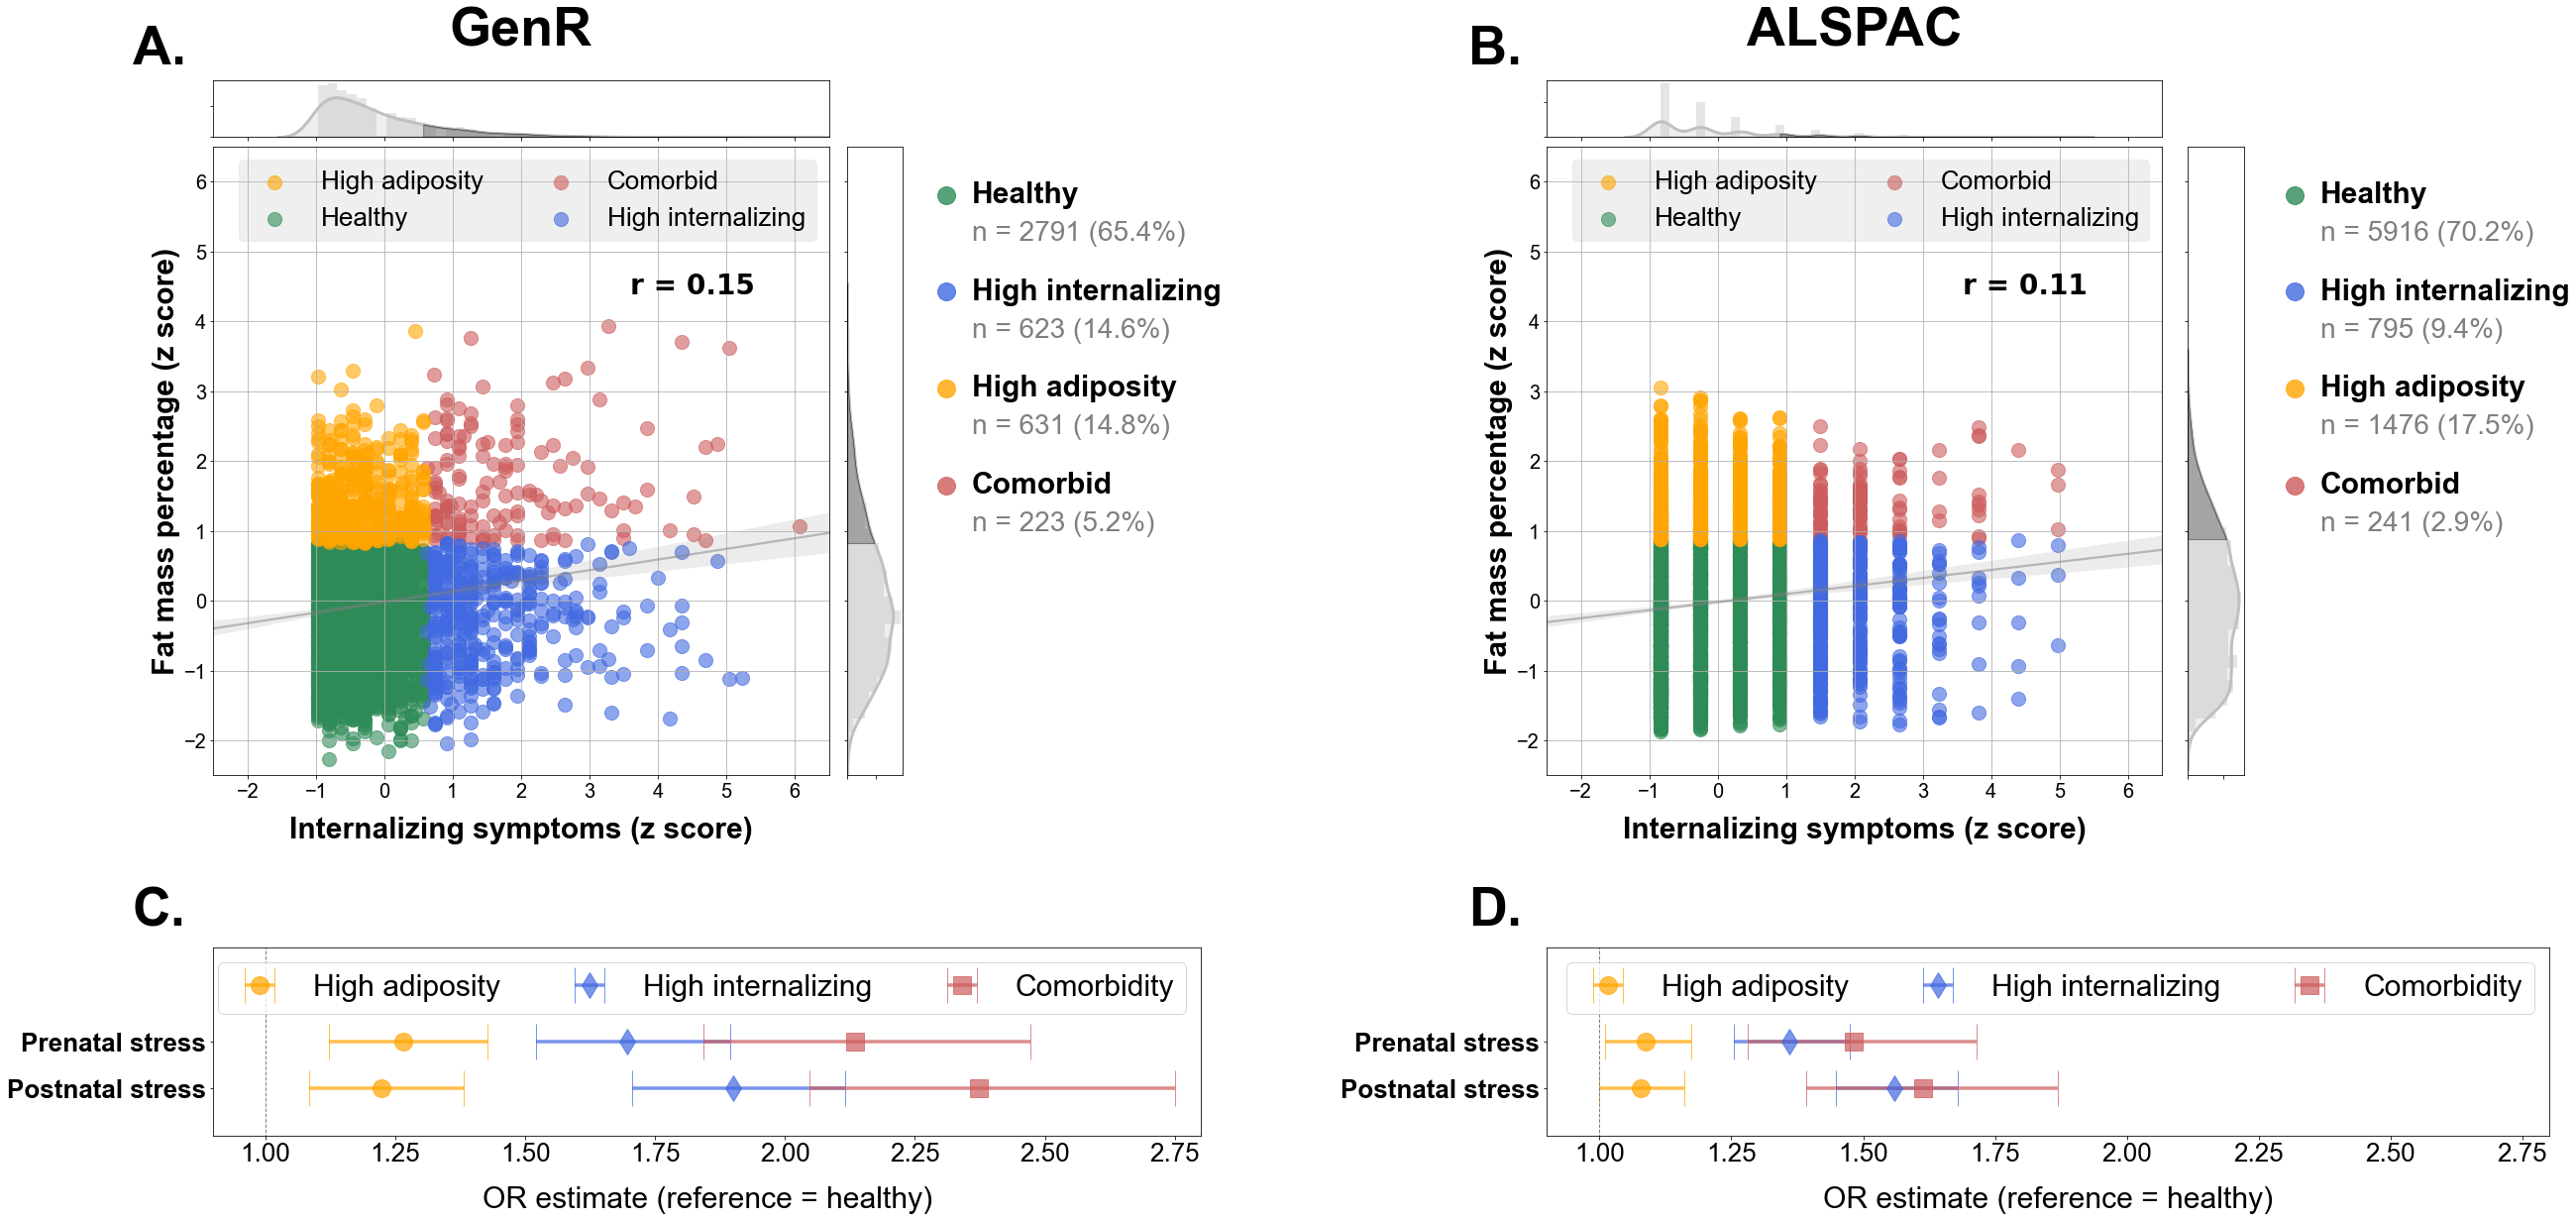

In [147]:

f, ax = plt.subplot_mosaic([['G.histx','.','.','.','A.histx','.','.'], 
                            ['G.main','G.histy','G.pie','.','A.main','A.histy','A.pie'],
                            ['.','.','.','.','.','.','.'],
                            ['G.beta','G.beta','G.beta','.','A.beta','A.beta','A.beta']], 
                            width_ratios=[11,1,5, 2, 11,1,5],
                            height_ratios=[1,11,1.7,3.3],
                            layout='constrained', figsize=(36,17))

group_scatter(data=r, ax=ax['G.main'], 
                ax_histx=ax['G.histx'], 
                ax_histy=ax['G.histy'], 
                  ax_pie=ax['G.pie'], cohort='GenR', count = Rcount)
group_scatter(data=a, ax=ax['A.main'], 
                ax_histx=ax['A.histx'], 
                ax_histy=ax['A.histy'], 
                  ax_pie=ax['A.pie'], cohort='ALSPAC', count = Acount)

# Generate results plots
grps_plot(GENR_comorb, ax['G.beta'], "", fs=22, ms=10);
grps_plot(ALSP_comorb, ax['A.beta'], "", fs=22, ms=10);

# add a title 
ax['G.histx'].set_title('GenR', fontweight = 'bold', fontsize = 54, pad =35)
ax['A.histx'].set_title('ALSPAC', fontweight = 'bold', fontsize = 54, pad =35)

f.text(0.05, 0.95, 'A.', size=54, weight='bold')
f.text(0.57, 0.95, 'B.', size=54, weight='bold')

f.text(0.05, 0.24, 'C.', size=54, weight='bold')
f.text(0.57, 0.24, 'D.', size=54, weight='bold');

# save_figure('F3_nopie')

f.savefig( output_path +'F4_comorb.tiff', format='tiff', bbox_inches='tight', dpi=500)
# save_figure(output_fig3AB)

# Supplementary Figures
## Sex - stratified analyses

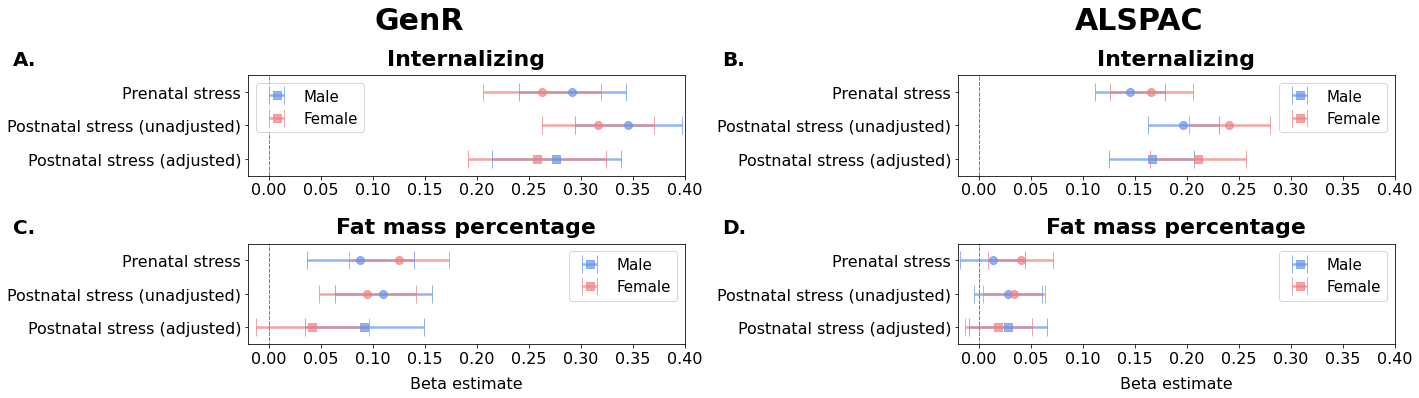

In [9]:
f, axs = plt.subplots(2, 2, figsize=(20, 5.3), constrained_layout = True)

plt.rcParams["font.family"] = "sans-serif"

lims=(-0.02, 0.4)
fc = 'lightcoral'
mc = 'cornflowerblue'

regr_plot(GENR_intern_m, axs[0,0], 'Internalizing', colors = mc, xlims=lims,sex='Male')
regr_plot(GENR_intern_f, axs[0,0], 'Internalizing', colors = fc, xlims=lims,sex='Female', leg='upper left')
regr_plot(ALSP_intern_m, axs[0,1], 'Internalizing', colors = mc, xlims=lims,sex='Male')
regr_plot(ALSP_intern_f, axs[0,1], 'Internalizing', colors = fc, xlims=lims,sex='Female')

regr_plot(GENR_fatmas_m, axs[1,0], 'Fat mass percentage', colors = mc, xlims=lims,sex='Male')
regr_plot(GENR_fatmas_f, axs[1,0], 'Fat mass percentage', colors = fc, xlims=lims,sex='Female')
regr_plot(ALSP_fatmas_m, axs[1,1], 'Fat mass percentage', colors = mc, xlims=lims,sex='Male')
regr_plot(ALSP_fatmas_f, axs[1,1], 'Fat mass percentage', colors = fc, xlims=lims,sex='Female')

f.subplots_adjust(hspace=0.8, wspace=0.61)

axs[1,0].set_xlabel('Beta estimate', fontsize=16, labelpad=10)
axs[1,1].set_xlabel('Beta estimate', fontsize=16, labelpad=10)

add_cohorts_suptitle()
add_letters(left=-0.54, up=1.1)
save_figure('SF3')

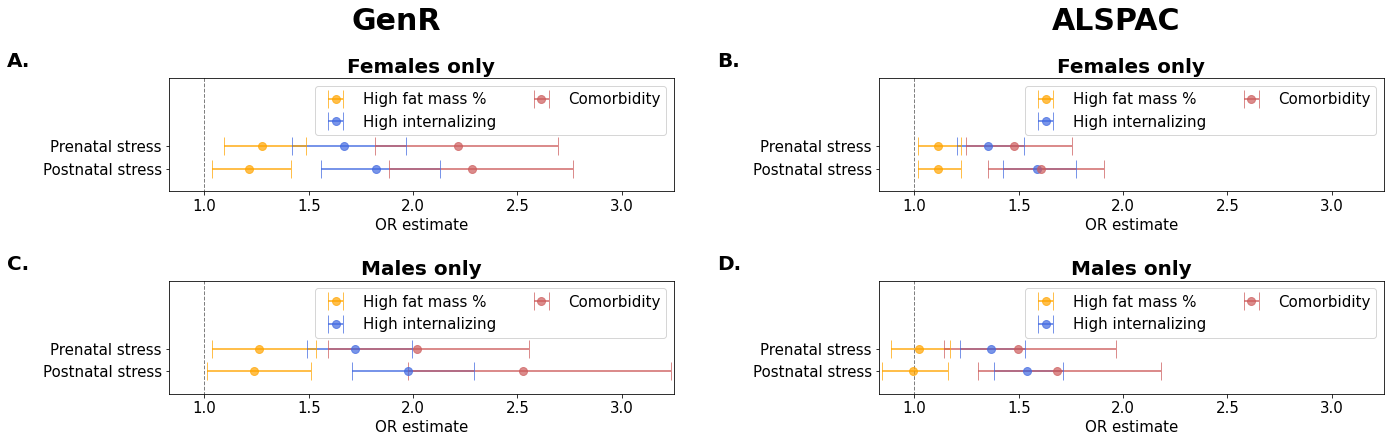

In [10]:
f, axs = plt.subplots(2, 2, figsize=(20, 5.9))

xlims = [0.83,3.25]

grps_plot(GENR_comorb_f, axs[0,0], "Females only");
grps_plot(GENR_comorb_m, axs[1,0], "Males only");
grps_plot(ALSP_comorb_f, axs[0,1], "Females only");
grps_plot(ALSP_comorb_m, axs[1,1], "Males only");

for ax in axs.flatten():
    ax.set_xlim(xlims); # custom x axis limits 

f.tight_layout()
add_cohorts_suptitle()
add_letters(left=-0.32, up=1.1)

save_figure('SF4')

## Domain contribution analyses

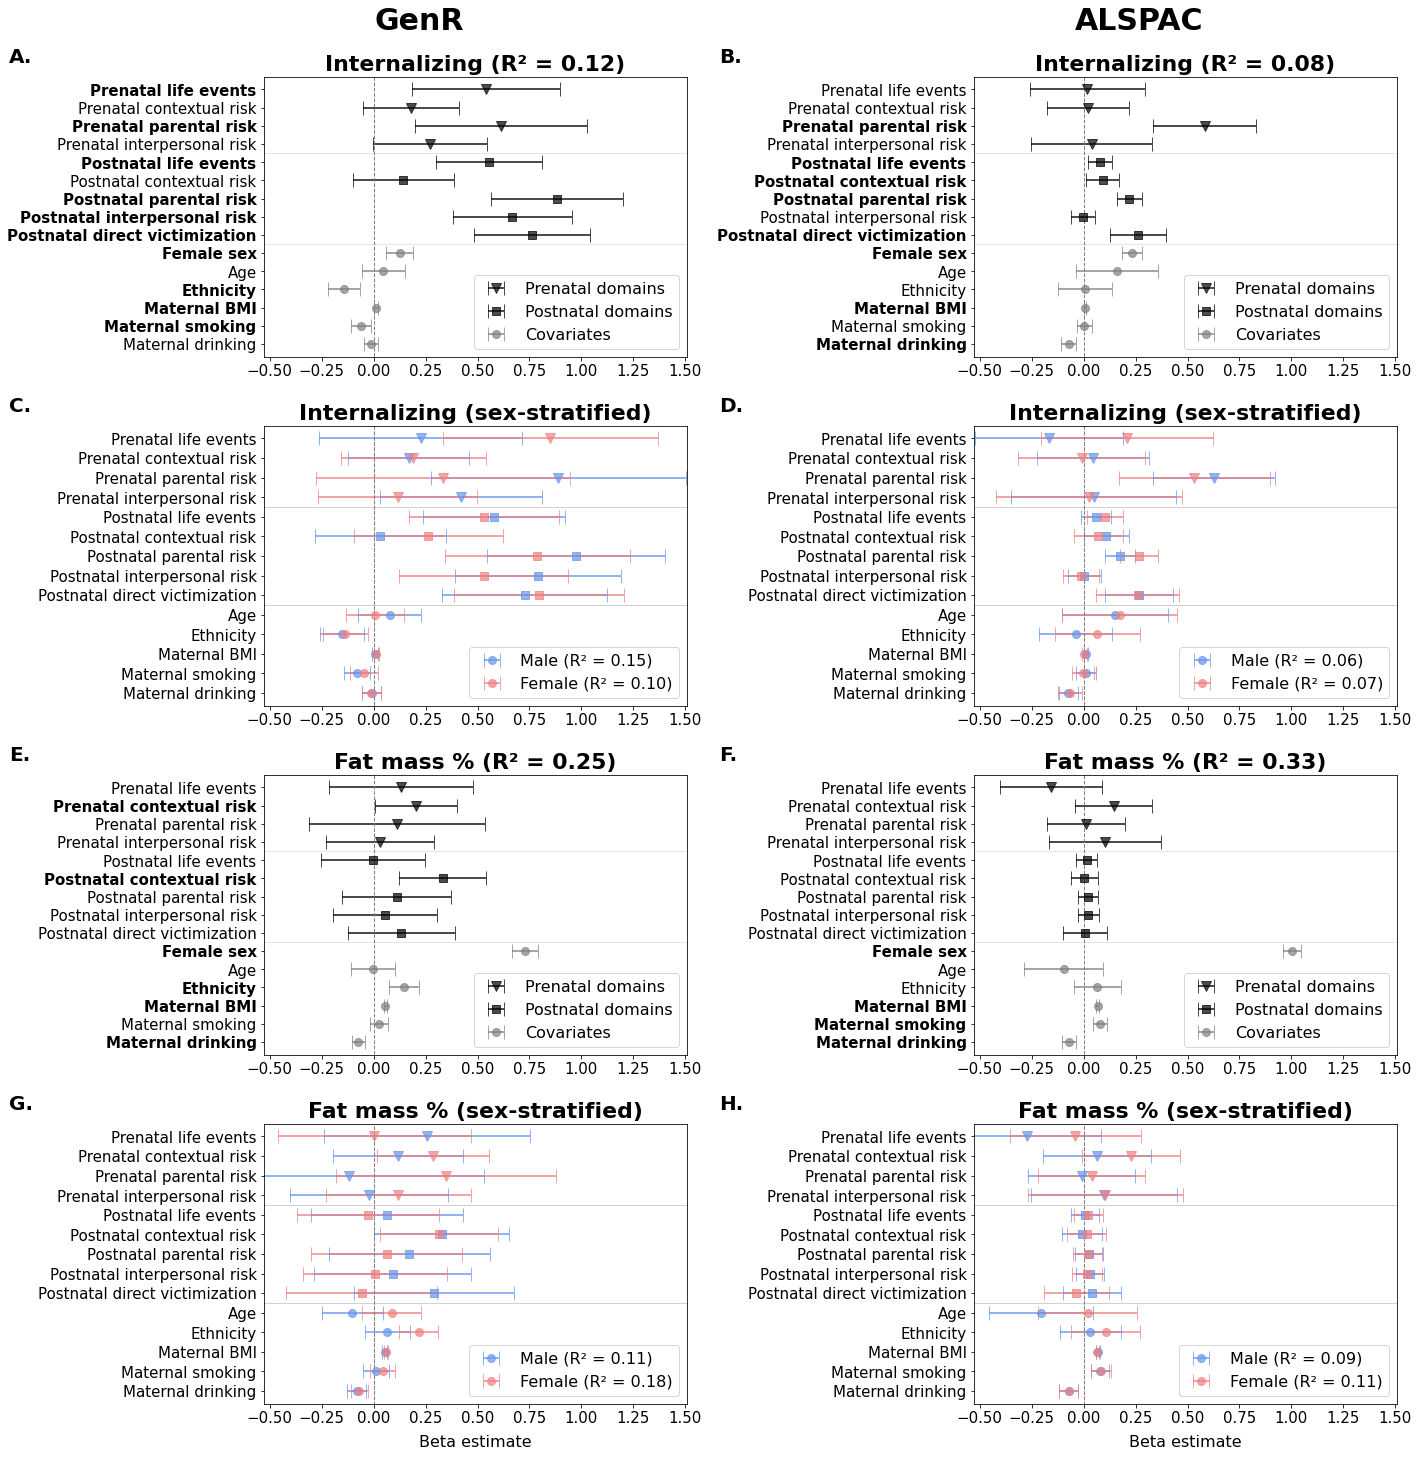

In [11]:
def dms_plot(cohort, outcome, title, ax, sex = '', xlims=(-0.53,1.51), lin=True, compare='',
             include_intercept = False, stress_only = False, bold_sign=True):
    
    if sex =='':
        model = title
        clr = 'k'; cov_clr = 'grey'
        pre_lab = 'Prenatal domains'; post_lab = 'Postnatal domains'; cov_lab = 'Covariates'
    elif sex =='m':
        model ='Male: '+ title.lower()
        clr = cov_clr = 'cornflowerblue'
    else:
        model ='Female: '+ title.lower()
        clr = cov_clr = 'lightcoral'
    
    # read in the dataframes
    a = globals()[outcome].get_group('domain model')
    a = a.loc[a['outcome'] == model]
    
    # determine what rows to plot (include/exclude intercept and covariates)
    s = 0 if include_intercept == True else 1
    s1 = 9 if stress_only == True else a.shape[0]
    
    # specify more readable names for the labels
    y = ['Prenatal life events', 'Prenatal contextual risk', 'Prenatal parental risk','Prenatal interpersonal risk', 
         'Postnatal life events', 'Postnatal contextual risk','Postnatal parental risk', 'Postnatal interpersonal risk',
         'Postnatal direct victimization'] + effects[2:]
    if sex != '':
        y.remove('Female sex') # for sex specific models
        pre_lab = post_lab = cov_lab = 'Female (R\u00B2 = %0.2f)' %round(a.rsq[0],2) if sex == 'f' else 'Male (R\u00B2 = %0.2f)' %round(a.rsq[0],2)
    if stress_only:
        y = y[:9]
        ax.set_ylim(-3,8.5) # I add some extra space to the y axis to fit a legend
    
    # plot the model estimates
    ax.errorbar(a.estimate[s:5],  y[:4], xerr = a['std.error'][s:5]*1.96, color = clr, label = pre_lab,
                fmt = 'v', ms=10, elinewidth = elw, capsize = caps, alpha=alph)
    ax.errorbar(a.estimate[5:10], y[4:9],xerr = a['std.error'][5:10]*1.96,color = clr, label = post_lab,
                fmt = 's', ms=8, elinewidth = elw, capsize = caps, alpha=alph)
    if not stress_only:
        ax.errorbar(a.estimate[10:],y[9:],xerr = a['std.error'][10:]*1.96,color = cov_clr, label = cov_lab,
                    fmt = 'o', ms=8, elinewidth = elw, capsize = caps, alpha=alph)
    # add a vertical dotted line indicating beta = 0.
    ax.axvline(x = 0, ymin = -1, ymax = 4, color = 'grey', ls = '--', lw = 1)
    
    # add horizontal lines to better distinguish prenatal / postnatal / covariates
    ax.axhline(y = 3.5, xmin = -1, xmax = 4, color = 'grey', ls = '-', lw = 1, alpha=.2)
    ax.axhline(y = 8.5, xmin = -1, xmax = 4, color = 'grey', ls = '-', lw = 1, alpha=.2)
        
    ax.invert_yaxis() # reorder top to bottom
    ax.set_xlim(xlims) # custom x axis limits 
    
    # add a legend
    ax.legend(fontsize=16)
    if sex != '':
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), fontsize=16, loc='lower right', ncol=1)
    # add title
    T = title + ' (R\u00B2 = %0.2f)' %round(a.rsq[0],2) if sex=='' else title + ' (sex-stratified)'
    ax.set_title(T, fontweight = 'bold', fontsize = 22)
    
    # estimate labels
    ax.tick_params(axis='both', which='major', labelsize=15)
    # bolden the names of significant estimates (in the additive model)
    if bold_sign == True:
        bold_significant(a,s,s1+1,ax)
# ==========================================================================

f, axs = plt.subplots(4, 2, figsize = (20, 20), constrained_layout = True)

dms_plot('GENR', outcome='GENR_intern_dm', title='Internalizing', ax=axs[0,0])
dms_plot('ALSP', outcome='ALSP_intern_dm', title='Internalizing', ax=axs[0,1])

dms_plot('GENR', outcome='GENR_intern_dm', title='Internalizing',ax=axs[1,0], sex = 'm', bold_sign=False)
dms_plot('GENR', outcome='GENR_intern_dm', title='Internalizing',ax=axs[1,0], sex = 'f', bold_sign=False)
dms_plot('ALSP', outcome='ALSP_intern_dm', title='Internalizing',ax=axs[1,1], sex = 'm', bold_sign=False)
dms_plot('ALSP', outcome='ALSP_intern_dm', title='Internalizing',ax=axs[1,1], sex = 'f', bold_sign=False)

dms_plot('GENR', outcome='GENR_fatmas_dm', title='Fat mass %', ax=axs[2,0])
dms_plot('ALSP', outcome='ALSP_fatmas_dm', title='Fat mass %', ax=axs[2,1])

dms_plot('GENR', outcome='GENR_fatmas_dm', title='Fat mass %',ax=axs[3,0], sex = 'm', bold_sign=False)
dms_plot('GENR', outcome='GENR_fatmas_dm', title='Fat mass %',ax=axs[3,0], sex = 'f', bold_sign=False)
dms_plot('ALSP', outcome='ALSP_fatmas_dm', title='Fat mass %',ax=axs[3,1], sex = 'm', bold_sign=False)
dms_plot('ALSP', outcome='ALSP_fatmas_dm', title='Fat mass %',ax=axs[3,1], sex = 'f', bold_sign=False)

axs[1,0].invert_yaxis(); axs[1,1].invert_yaxis(); axs[3,0].invert_yaxis(); axs[3,1].invert_yaxis()

axs[3,0].set_xlabel('Beta estimate', fontsize=16, labelpad=9)
axs[3,1].set_xlabel('Beta estimate', fontsize=16, labelpad=9)

add_cohorts_suptitle(0.30, 0.80)
add_letters(-0.6, 1.05)
f.subplots_adjust(wspace=0.8)
save_figure('SF5')

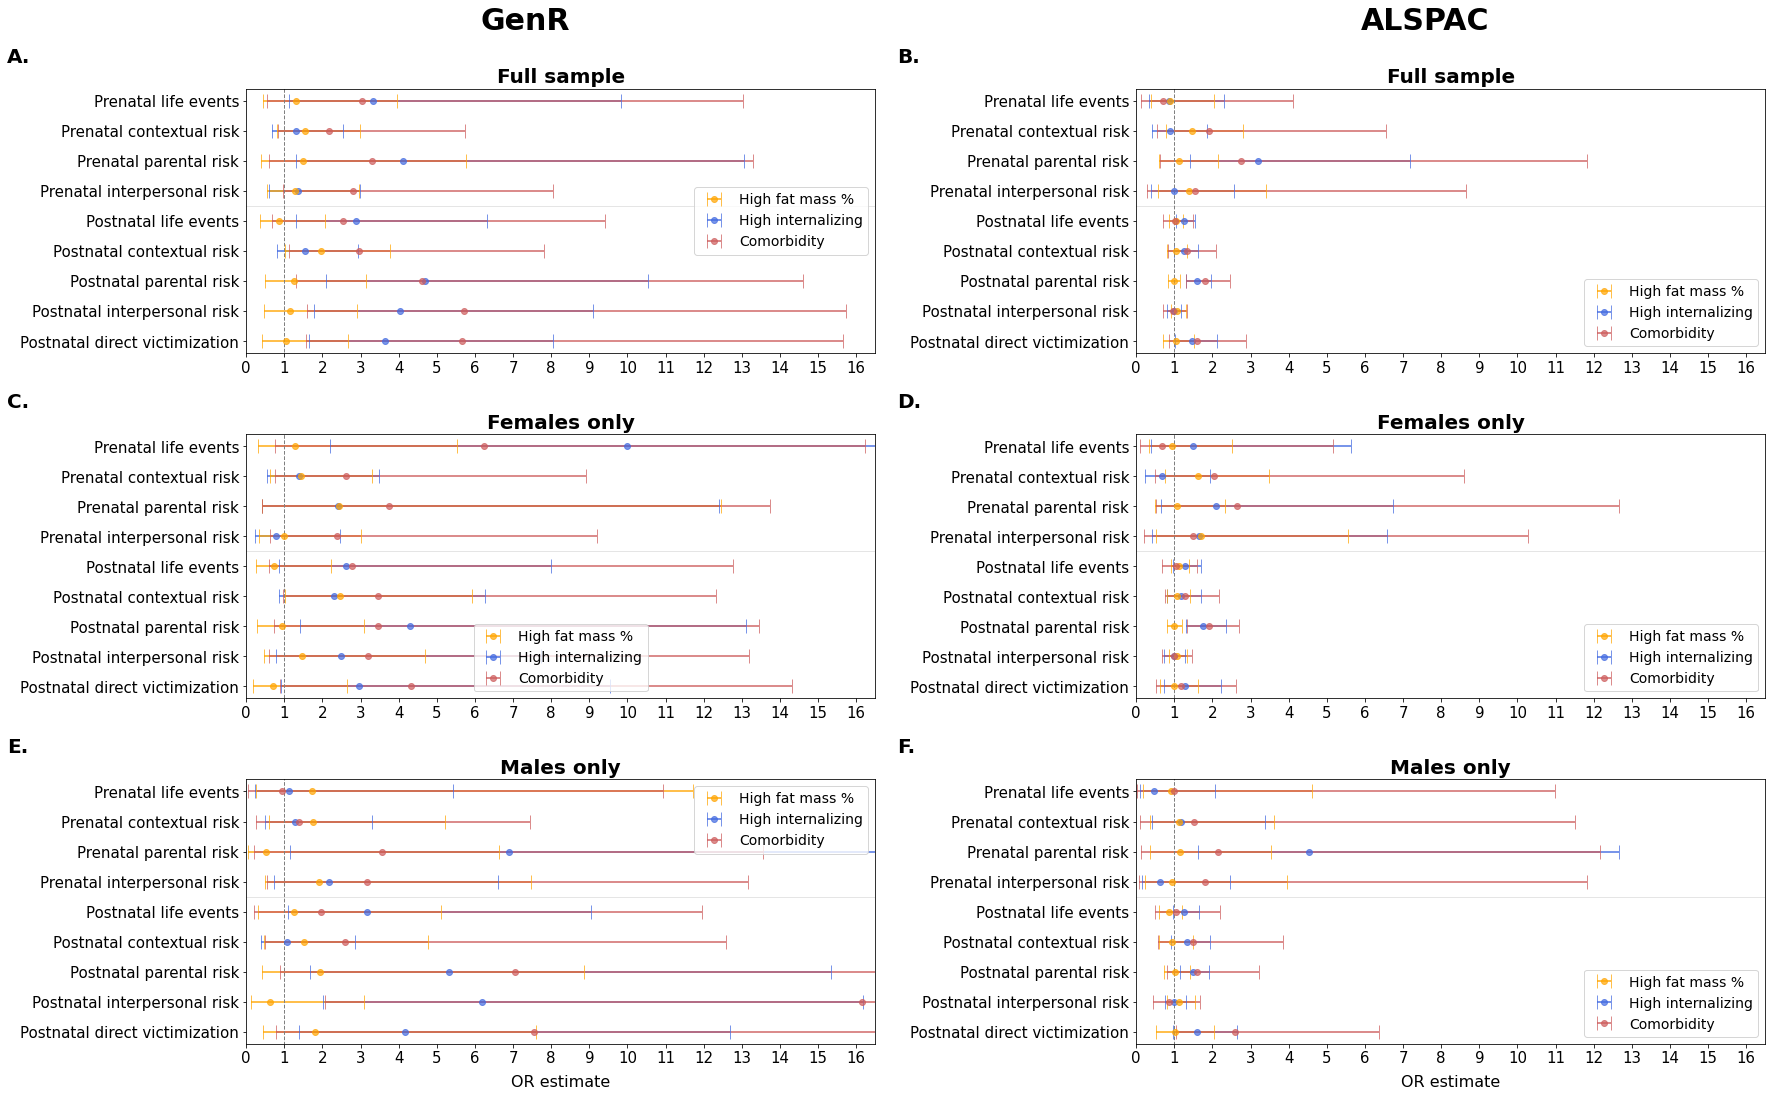

In [12]:
fullR = GENR_comorb_dm.loc[GENR_comorb_dm['outcome']=='Comorbidity',]
femaR = GENR_comorb_dm.loc[GENR_comorb_dm['outcome']=='Female: comorbidity',]
maleR = GENR_comorb_dm.loc[GENR_comorb_dm['outcome']=='Male: comorbidity',]

fullA = ALSP_comorb_dm.loc[ALSP_comorb_dm['outcome']=='Comorbidity',]
femaA = ALSP_comorb_dm.loc[ALSP_comorb_dm['outcome']=='Female: comorbidity',]
maleA = ALSP_comorb_dm.loc[ALSP_comorb_dm['outcome']=='Male: comorbidity',]

def grp_dm_plot(data, ax, title, lbls=('High internalizing','High fat mass %', 'Comorbidity'), 
                          clrs=('royalblue','orange','indianred'), bold_sign=True):
    for n, term in enumerate(data.index.unique()[1:10]):
        t = data.loc[term]
        t_or = t['OR']
        t_lc = t_or - t['lci']
        t_uc = t['uci'] - t_or
        
        t_uc = [i if i < 10 else 10 for i in t_uc]

        for j in range(3):
            ax.errorbar(t_or[j], n, xerr = [[t_lc[j]], [t_uc[j]]], color = clrs[j], label = lbls[j],
                                  fmt = fmt, elinewidth = elw, capsize = caps, alpha = alph)
        
    # add a vertical dotted line indicating beta = 0 or OR = 1.
    ax.axvline(x = 1, ymin = -1, ymax = 4, color = 'grey', ls = '--', lw = 1)
    ax.axhline(y = 3.5, xmin = -1, xmax = 4, color = 'grey', ls = '-', lw = 1, alpha=.2)
    
    ax.invert_yaxis()
    ax.set_yticks(range(0,9))
    ax.set_yticklabels(['Prenatal life events', 'Prenatal contextual risk', 'Prenatal parental risk','Prenatal interpersonal risk', 
             'Postnatal life events', 'Postnatal contextual risk','Postnatal parental risk', 'Postnatal interpersonal risk',
             'Postnatal direct victimization']);
   
    ax.set_xticks(list(range(0,17)))
    ax.set_xlim(0,16.5)
    ax.set_title(title, fontsize=20, fontweight='bold')
    # estimate labels
    ax.tick_params(axis='both', which='major', labelsize=15)
    # add a legend
    handles, labels = ax.get_legend_handles_labels()
    order = [1,0,2]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
              fontsize=14, loc='best', ncol=1)
    
# ============================================================================
f, axs = plt.subplots(3, 2, figsize=(25, 15))

grp_dm_plot(fullR, axs[0,0], "Full sample")
grp_dm_plot(femaR, axs[1,0], "Females only")
grp_dm_plot(maleR, axs[2,0], "Males only")

grp_dm_plot(fullA, axs[0,1], "Full sample")
grp_dm_plot(femaA, axs[1,1], "Females only")
grp_dm_plot(maleA, axs[2,1], "Males only")

axs[2,0].set_xlabel('OR estimate', fontsize=16, labelpad=9)
axs[2,1].set_xlabel('OR estimate', fontsize=16, labelpad=9)

add_cohorts_suptitle()
add_letters(left=-0.38, up=1.1)

save_figure('SF6')

## Sensitivity analyses

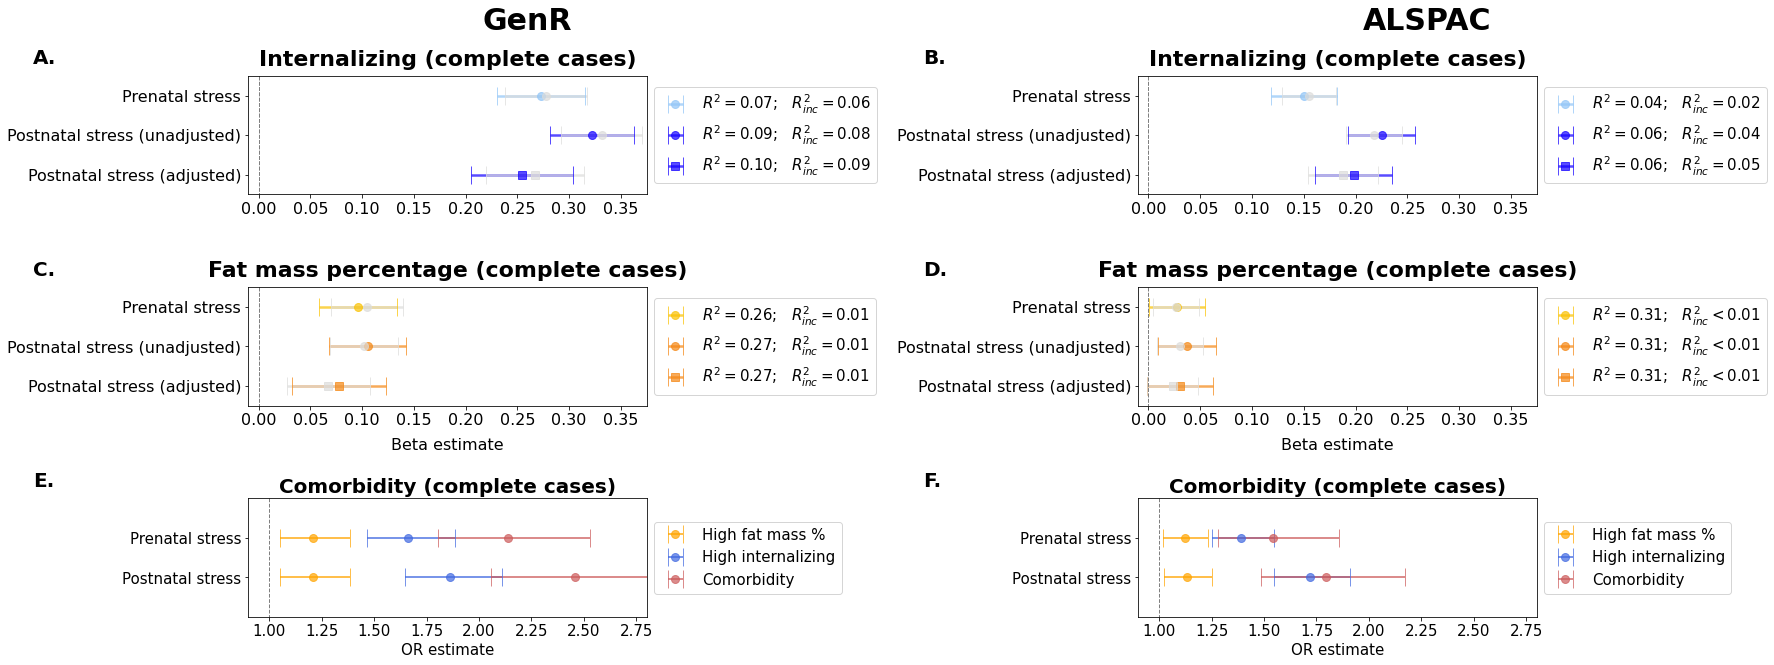

In [20]:
f, axs = plt.subplots(3, 2, figsize=(25, 9), constrained_layout = True)

plt.rcParams["font.family"] = "sans-serif"

regr_plot(GENR_intern_select, axs[0,0], 'Internalizing (complete cases)', colors=['#91C5F7', '#1300FF', '#1300FF'])
regr_plot(ALSP_intern_select, axs[0,1], 'Internalizing (complete cases)', colors=['#91C5F7', '#1300FF', '#1300FF'])
regr_plot(GENR_fatmas_select, axs[1,0], 'Fat mass percentage (complete cases)', colors=['#FAC202', '#F58713', '#F58713'])
regr_plot(ALSP_fatmas_select, axs[1,1], 'Fat mass percentage (complete cases)', colors=['#FAC202', '#F58713', '#F58713'])

regr_plot(GENR_intern, axs[0,0], 'Internalizing (complete cases)',colors=['#DCDCDB']*3, leg='off')
regr_plot(ALSP_intern, axs[0,1], 'Internalizing (complete cases)',colors=['#DCDCDB']*3, leg='off')
regr_plot(GENR_fatmas, axs[1,0], 'Fat mass percentage (complete cases)',colors=['#DCDCDB']*3, leg='off')
regr_plot(ALSP_fatmas, axs[1,1], 'Fat mass percentage (complete cases)',colors=['#DCDCDB']*3, leg='off')

grps_plot(GENR_comorb_select, axs[2,0], "Comorbidity (complete cases)", leg='out');
grps_plot(ALSP_comorb_select, axs[2,1], "Comorbidity (complete cases)", leg='out');

f.subplots_adjust(hspace=0.8, wspace=4)

axs[1,0].set_xlabel('Beta estimate', fontsize=16, labelpad=10)
axs[1,1].set_xlabel('Beta estimate', fontsize=16, labelpad=10)

add_cohorts_suptitle()
add_letters(left=-0.54, up=1.1)
save_figure('SF7')

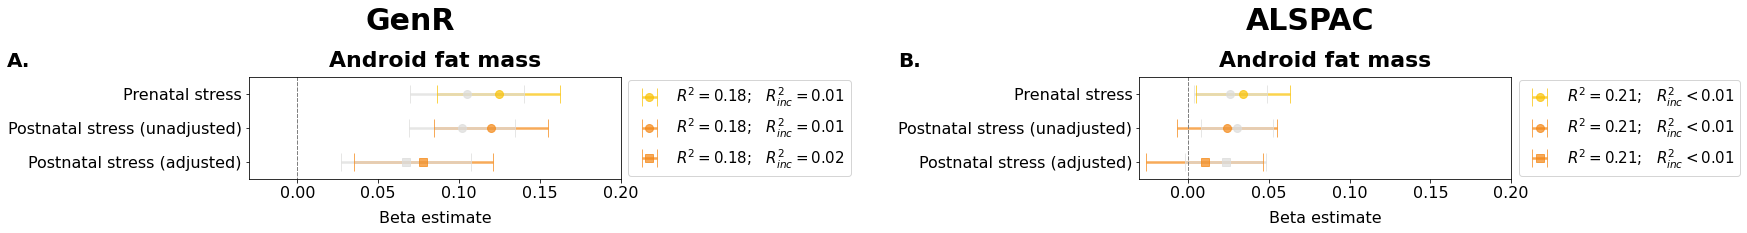

In [14]:
f, axs = plt.subplots(1, 2, figsize=(25, 3), constrained_layout = True)

plt.rcParams["font.family"] = "sans-serif"

regr_plot(GENR_android, axs[0], 'Android fat mass', xlims=[-0.03,0.2], colors=['#FAC202', '#F58713', '#F58713'])
regr_plot(ALSP_android, axs[1], 'Android fat mass', xlims=[-0.03,0.2], colors=['#FAC202', '#F58713', '#F58713'])

regr_plot(GENR_fatmas, axs[0], 'Android fat mass', xlims=[-0.03,0.2],colors=['#DCDCDB']*3, leg='off')
regr_plot(ALSP_fatmas, axs[1], 'Android fat mass', xlims=[-0.03,0.2],colors=['#DCDCDB']*3, leg='off')

axs[0].set_xlabel('Beta estimate', fontsize=16, labelpad=10)
axs[1].set_xlabel('Beta estimate', fontsize=16, labelpad=10)

f.tight_layout()
add_cohorts_suptitle(0.25, 0.75)
add_letters(left=-0.65, up=1.1)
save_figure('SF8')

In [59]:
# Carmine's suggestion 
xl = pd.ExcelFile('/Users/Serena/Desktop/mockData/Results/2022-05-19_nopre_Results.xlsx') # read multiple sheets
# loop through the sheets and save the contents in separate dataframes
for sheet in xl.sheet_names:
    # print(sheet)
    globals()[sheet] = xl.parse(sheet) 
    globals()[sheet] = globals()[sheet].set_index('term') 
#nopre_intern
#nopre_fatmas

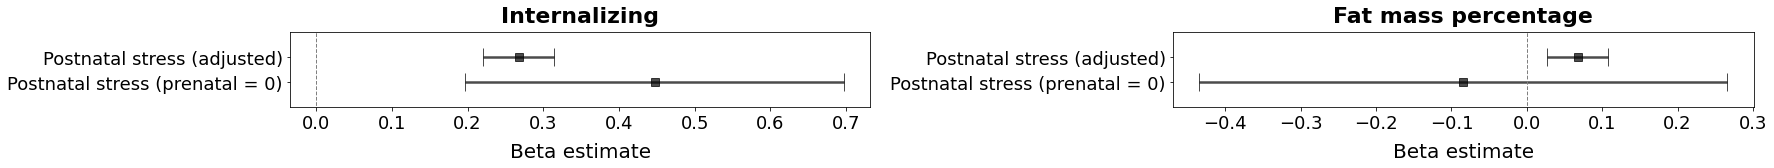

In [61]:
f, axs = plt.subplots(1, 2, figsize=(25, 2.7), constrained_layout = True)


axs[0].errorbar([nopre_intern['estimate'][1], GENR_intern.get_group('pren+post model')['estimate'][2]], 
                ["Postnatal stress (prenatal = 0)","Postnatal stress (adjusted)"], 
                xerr = [nopre_intern['std.error'][1]*1.96, GENR_intern.get_group('pren+post model')['std.error'][2]*1.96], 
                label = '$R^{2}=$%0.2f'%round(nopre_intern.rsq[0],2),
                color = 'k', ms=8, fmt = 's', elinewidth = 2.5, capsize = 9, alpha = alph)

axs[1].errorbar([nopre_fatmas['estimate'][1], GENR_fatmas.get_group('pren+post model')['estimate'][2]], 
                ["Postnatal stress (prenatal = 0)","Postnatal stress (adjusted)"], 
                xerr = [nopre_fatmas['std.error'][1]*1.96, GENR_fatmas.get_group('pren+post model')['std.error'][2]*1.96], 
                label = '$R^{2}=$%0.2f'%round(nopre_fatmas.rsq[0],2),
                color = 'k', ms=8, fmt = 's', elinewidth = 2.5, capsize = 9, alpha = alph)
for ax in axs:
    ax.set_ylim(-1,2)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.axvline(x = 0, ymin = -1, ymax = 2, color = 'grey', ls = '--', lw = 1)
    ax.set_xlabel('Beta estimate', fontsize=20, labelpad=10)

axs[0].set_title('Internalizing', fontweight = 'bold', fontsize = 22, pad =10)
axs[1].set_title('Fat mass percentage', fontweight = 'bold', fontsize = 22, pad =10)

save_figure('SF_nopren')

### Help with the results section (print results) 

In [16]:
def print_res(outcome, OR=False):
    print('\n', outcome.get_group('pren model')['outcome'][0])
    pren = outcome.get_group('pren model').loc['prenatal_stress_z']
    post = outcome.get_group('post model').loc['postnatal_stress_z']
    muad = outcome.get_group('pren+post model').loc[['prenatal_stress_z', 'postnatal_stress_z']]
    if not OR:
        pren = pren.to_frame().T
        post = post.to_frame().T
    for res in [pren, post, muad]:
        for s in range(len(res)):
            if OR: 
                print(res.index[s],'\t', res['model'][s], '\t', res['y.level'][s], '\t', 
                      round(res['OR'][s],2),' [', 
                      round(res['lci'][s],2),', ',round(res['uci'][s],2),']', sep ="")
            else:
                p = round(res['p.value'][s],3)
                val = '< .001' if p < 0.001 else '= '+str(p)[1:]
                print(res.index[s],'\t', res['model'][s], '\t', 
                      round(res['estimate'][s],2), 
                      ', t(', round(res['df'][s],1),') = ', round(res['statistic'][s],1),
                      ', P ',val, sep ="")
                
def print_dmres(outcome, OR=False):
    print('\n', outcome.get_group('domain model')['outcome'][0])
    res = outcome.get_group('domain model').loc[['pre_life_events', 'pre_contextual_risk',
       'pre_parental_risk', 'pre_interpersonal_risk', 'post_life_events','post_contextual_risk',
        'post_parental_risk', 'post_interpersonal_risk','post_direct_victimization']]
    for s in range(len(res)):
        if OR: 
            print(res.index[s],'\t', res['model'][s], '\t', res['y.level'][s], '\t', 
                  round(res['OR'][s],2),' [', 
                  round(res['lci'][s],2),', ',round(res['uci'][s],2),']', sep ="")
        else:
            p = round(res['p.value'][s],3)
            val = '< .001' if p < 0.001 else '= '+str(p)[1:]
            print(res.index[s],'\t', res['model'][s], '\t', 
                  round(res['estimate'][s],2), 
                  ', t(', round(res['df'][s],1),') = ', round(res['statistic'][s],1),
                  ', P ',val, sep ="")

### Old plots (masuscript v2)

In [17]:
# # Set the colors indicating prenatal and postnatal effects
# p1 = sns.color_palette('colorblind')[3] # ('Paired')[4]
# p2 = sns.color_palette('colorblind')[2] # ('Set2')[0]

# def mainres_plot(cohort, title, ax, xlims, lin=True, compare='', sex='', 
#                  include_intercept=False, stress_only=False, incrR2=0, bold_sign=True):
#     plt.rcParams["font.family"] = "sans-serif"
#     # read in the dataframes
#     a = globals()[cohort+sex].get_group('pren+post model')
#     i = globals()[cohort+sex].get_group('pren model')
#     j = globals()[cohort+sex].get_group('post model')
#     if lin:
#         # append pre and postnatal stress to the respective single models
#         i = i.append(pd.Series(name='postnatal_stress_z')).reindex(a.index)
#         j = j.append(pd.Series(name='prenatal_stress_z')).reindex(a.index)
#     elif lin == False:
#         # read in the dataframes, selecting by comparison 
#         a = a.loc[a['y.level'] == compare]
#         i = i.loc[i['y.level'] == compare]
#         j = j.loc[j['y.level'] == compare]
#         # append pre and postnatal stress to the respective single models
#         i = i.append(pd.Series(name='postnatal_stress_z')).reindex(a.index)
#         j = j.append(pd.Series(name='prenatal_stress_z')).reindex(a.index)
#         # create limits of the CIs in in differential terms (for errorbar to read)
#         a['LCI'] = a.OR-a.lci; a['UCI'] = a.uci-a.OR
#         i['LCI'] = i.OR-i.lci; i['UCI'] = i.uci-i.OR
#         j['LCI'] = j.OR-j.lci; j['UCI'] = j.uci-j.OR
    
#     # determine what rows to plot (include/exclude intercept and covariates)
#     s = 0 if include_intercept == True else 1
#     s1 = 3 if stress_only == True else a.shape[0]
#     y = effects   # rename the labels
#     if sex != '': # for the sex specific models
#         y = [i for i in effects if i != 'Female sex']
#     if stress_only:
#         y = effects[:2]
#         ax.set_ylim(-3,1.5) # I add some extra space to the y axis to fit a legend
#         if incrR2 != 0:
#             ax.text(0.38, 0.3, "$R^{2}_{inc} = $"+str(round(i.rsq[0]-incrR2,2)), color=p1, fontweight='bold', fontsize=12)
#             ax.text(0.38, 1.2, "$R^{2}_{inc} = $"+str(round(j.rsq[0]-incrR2,2)), color=p2, fontweight='bold', fontsize=12)
    
#     def overlap_estimates(mdls, axis, start, end, y, linear = True,
#                       clrs=[p1,p2,'k'], lbls=['Prenatal only', 'Postnatal only','Mutually adjusted']):
#         reference = 0 if linear else 1
#         for m, md in enumerate(mdls):
#             c = clrs[m]; lb = lbls[m]
#             # draw these mf   
#             if linear:
#                 axis.errorbar(md['estimate'][start:end], y, xerr = md['std.error'][start:end]*1.96, color = c, 
#                               label = lb + ' (R\u00B2 = %0.2f)'%round(md.rsq[0],2),
#                               fmt = fmt, elinewidth = elw, capsize = caps, alpha = alph)
#             elif linear == False:
#                 axis.errorbar(md['OR'][start:end], y, xerr = [md['LCI'][start:end], md['UCI'][start:end]], color = c, 
#                               label = lb,
#                               fmt = fmt, elinewidth = elw, capsize = caps, alpha = alph)
#         # add a vertical dotted line indicating beta = 0 or OR = 1.
#         axis.axvline(x = reference, ymin = -1, ymax = 4, color = 'grey', ls = '--', lw = 1)
    
#     # Draw the estimates 
#     overlap_estimates(mdls=[i,j,a], axis=ax, start=s, end=s1, y=y, linear=lin)
    
#     ax.invert_yaxis() # reorder top to bottom
#     ax.set_xlim(xlims) # custom x axis limits 
#     # add a legend
#     legend_pos = 'upper right' if stress_only else 'lower right'
#     ax.legend(fontsize=12, loc=legend_pos, ncol=1)
#     # add a title 
#     spec = '' if lin else 'OR = Comorbid / '
#     sz = 18 if lin else 15
#     ax.set_title(spec+title, fontweight = 'bold', fontsize = sz)
#     # add estimate labels
#     ax.tick_params(axis='y', which='major', labelsize=14) # 12
#     # bolden the names of significant estimates (in the additive model)
#     if bold_sign == True:
#         bold_significant(a,s,s1,ax)
        
# ====================================================================================================================
# f, axs = plt.subplots(2, 2, figsize = (15, 5.5), constrained_layout = True)

# lm = (-0.04,0.5)

# mainres_plot('GENR_intern', title='Internalizing', ax=axs[0,0], xlims=lm, stress_only=True, 
#              incrR2=GENR_intern.get_group('base model')['rsq'][0])
# mainres_plot('GENR_fatmas', title='Fat mass %',    ax=axs[1,0], xlims=lm, stress_only=True, 
#              incrR2=GENR_fatmas.get_group('base model')['rsq'][0])
# mainres_plot('ALSP_intern', title='Internalizing', ax=axs[0,1], xlims=lm, stress_only=True, 
#              incrR2=ALSP_intern.get_group('base model')['rsq'][0])
# mainres_plot('ALSP_fatmas', title='Fat mass %',    ax=axs[1,1], xlims=lm, stress_only=True, 
#              incrR2=ALSP_fatmas.get_group('base model')['rsq'][0])

# axs[1,0].set_xlabel('Beta estimate', fontsize=13, labelpad=9)
# axs[1,1].set_xlabel('Beta estimate', fontsize=13, labelpad=9)

# add_cohorts_suptitle()
# add_letters()
# save_figure('Fig1')

# ====================================================================================================================
# f, axs = plt.subplots(3, 2, figsize = (15, 7.5), constrained_layout = True)

# lm = (0.8, 3) # (0.5, 8)

# mainres_plot('GENR_comorb',title="Healthy",           lin=False,compare='M:healthy',ax=axs[0,0], xlims=lm, stress_only=True)
# mainres_plot('GENR_comorb',title="High fat % only",   lin=False,compare='M:fatmas', ax=axs[1,0], xlims=lm, stress_only=True)
# mainres_plot('GENR_comorb',title="Internalizing only",lin=False,compare='M:intern', ax=axs[2,0], xlims=lm, stress_only=True)
# mainres_plot('ALSP_comorb',title="Healthy",           lin=False,compare='M:healthy',ax=axs[0,1], xlims=lm, stress_only=True)
# mainres_plot('ALSP_comorb',title="High fat % only",   lin=False,compare='M:fatmas', ax=axs[1,1], xlims=lm, stress_only=True)
# mainres_plot('ALSP_comorb',title="Internalizing only",lin=False,compare='M:intern', ax=axs[2,1], xlims=lm, stress_only=True)

# axs[2,0].set_xlabel('OR estimate', fontsize=13, labelpad=9)
# axs[2,1].set_xlabel('OR estimate', fontsize=13, labelpad=9)

# # add_cohorts_suptitle()
# add_letters(from_letter=2)
# save_figure('Fig2')